<a href="https://colab.research.google.com/github/denial123/lstm-gan/blob/master/cgan_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        100         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1, 100)       5100        embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100, 1)       0                                            
____________________________________________________________________________________________

ValueError: ignored

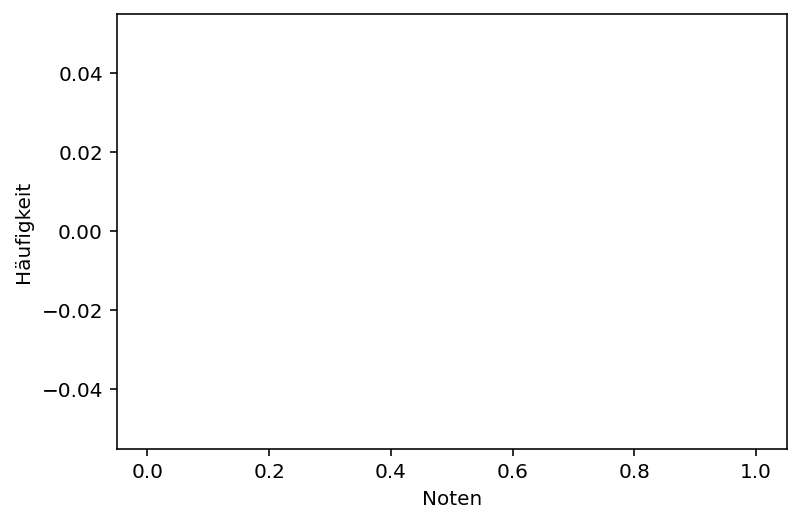

In [1]:
from __future__ import print_function, division
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
import tensorflow as tf

from music21 import converter, instrument, note, chord, stream
from keras.layers import Input, Dense, Reshape, Dropout, LSTM, Bidirectional
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, model_from_json
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from numpy import asarray
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate


def get_notes(dir="love_simple/*.mid"):
    """ Get all the notes and chords from the midi files """
    notes = []

    for file in glob.glob(dir):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try:  # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse()
        except:  # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    return notes


def prepare_sequences(notes, n_vocab, label_number=0):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 100

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))

    # Create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # Reshape the input into a format compatible with LSTM layers
    #network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    network_input = asarray(network_input)
    # Normalize input between -1 and 1
    network_input = (network_input - float(n_vocab) / 2) / (float(n_vocab) / 2)
    print("network output before categorical", network_output)
    #network_output = np_utils.to_categorical(network_output)

    label = []
    for i in range(0, n_patterns):
        label.append(label_number)
    #label = np_utils.to_categorical(label, num_classes=2)
    print("network_input", network_input)
    print(len(label))
    #print("label",label)


    # Versuch ohne eckige Klammern
    return (network_input, label, network_output)


def create_midi(prediction_output, filename):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for item in prediction_output:
        pattern = item[0]
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.show('text')
    # show MuseScore
    #midi_stream.show()
    # einkommentieren, um midi file zu speichern
    midi_stream.write('midi', fp='{}.mid'.format(filename))


class GAN():
    def __init__(self, rows, load_model=False):
        self.seq_length = rows
        self.seq_shape = (self.seq_length, 1)
        self.latent_dim = 1000
        self.disc_loss = []
        self.disc_loss_real = []
        self.disc_loss_fake = []
        self.gen_loss = []
        self.d_acc_real = []
        self.d_acc_fake = []
        self.n_classes = 2

        self.model_save_dir = 'cgan_saved_model'

        if load_model:
            self.load_model()
        else:
            self.init_model()

    def load_model(self):
        optimizer = Adam(0.0002, 0.5)

        # Load and compile the discriminator
        self.discriminator = self.load_keras_model("cdiscriminator_model")
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Load the generator
        self.generator = self.load_keras_model("cgenerator_model")
        # Get noise and label input from generator model
        gen_noise, gen_label = self.generator.input
        # Get output sequence from the generator model
        generated_seq = self.generator.output

        # [ucgan] The generator takes noise as input and generates imgs
        #z = Input(shape=(self.latent_dim,))
        #generated_seq = self.generator(z)

        # Connect output sequence and label input from generator as inputs to discriminator
        gan_output = self.discriminator([generated_seq, gen_label])

        # [ucgan] The discriminator takes generated images as input and determines validity = gan_output
        # validity = self.discriminator(generated_seq)
        # self.combined = Model(z, validity)
        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = self.load_keras_model("ccombined_model")
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


        ###

    def init_model(self):
        #in image example: method "define gan()"
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Build the generator
        self.generator = self.build_generator()
        # Get noise and label input from generator model
        gen_noise, gen_label = self.generator.input

        # Get output sequence from the generator model
        generated_seq = self.generator.output

        # [ucgan] The generator takes noise as input and generates note sequences
        #z = Input(shape=(self.latent_dim,))
        #generated_seq = self.generator(z)

        # Connect output sequence and label input from generator as inputs to discriminator
        gan_output = self.discriminator([generated_seq,gen_label])

        # [ucgan] The discriminator takes generated images as input and determines validity = gan_output
        #validity = self.discriminator(generated_seq)
        # self.combined = Model(z, validity)
        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([gen_noise, gen_label], gan_output)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_discriminator(self, in_shape=(100,1)):

        # label input
        in_label = Input(shape=(1,))
        # embedding for categorical input
        li = Embedding(self.n_classes, 50)(in_label)
        # scale up to seq_length (100) with linear activation
        li = Dense(self.seq_length)(li)
        # reshape to additional channel
        li = Reshape(self.seq_shape)(li)

        # sequence input
        in_seq = Input(shape=self.seq_shape)
        # concat label as a channel
        merge = Concatenate()([in_seq, li])

        fe = LSTM(512, return_sequences=True)(merge)
        fe = Bidirectional(LSTM(512))(fe)
        fe = Dense(512)(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dense(256)(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        # output
        out_layer = Dense(1, activation='sigmoid')(fe)

        # define model
        model = Model([in_seq, in_label], out_layer)
        model.summary()
        #plot_model(model, to_file='cdiscriminator_plot.png', show_shapes=True, show_layer_names=True)
        return model


        ### from image example
        # downsample
        #fe = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(merge)
        #fe = LeakyReLU(alpha=0.2)(fe)
        # downsample
        #fe = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(fe)
        #fe = LeakyReLU(alpha=0.2)(fe)
        # flatten feature maps
        #fe = Flatten()(fe)
        # dropout
        #fe = Dropout(0.4)(fe)
        # output
        #out_layer = Dense(1, activation='sigmoid')(fe)
        # define model
        #model = Model([in_image, in_label], out_layer)
        # compile model
        #opt = Adam(lr=0.0002, beta_1=0.5)
        #model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        #return model
        ### end-- from image example

        #-------old Sequential model
        #model = Sequential()
        #model.add(LSTM(512, input_shape=self.seq_shape, return_sequences=True))
        #model.add(Bidirectional(LSTM(512)))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(Dense(256))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(Dense(1, activation='sigmoid'))
        #model.summary()
        #plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

        #seq = Input(shape=self.seq_shape)
        #validity = model(seq)

        #return Model(seq, validity)
        #end-- old Sequential model

    def build_generator(self):
        # label input
        in_label = Input(shape=(1,))
        # embedding for categorical input
        li = Embedding(self.n_classes, 50)(in_label)

        #### testen, was besser geht
        #(A) scale up to latent_dim (1000) with linear activation
        #li = Dense(self.latent_dim)(li)
        #li = Reshape((self.latent_dim,))(li)
        #(B)
        li = Dense(1)(li)
        li = Reshape((1,))(li)

        in_lat = Input(shape=(self.latent_dim,))
        merge = Concatenate()([in_lat, li])
        gen = Dense(256)(merge)
        gen = LeakyReLU(alpha=0.2)(gen)
        gen = BatchNormalization(momentum=0.8)(gen)
        gen = Dense(512)(gen)
        gen = LeakyReLU(alpha=0.2)(gen)
        gen = BatchNormalization(momentum=0.8)(gen)
        gen = Dense(1024)(gen)
        gen = LeakyReLU(alpha=0.2)(gen)
        gen = BatchNormalization(momentum=0.8)(gen)
        out_layer = Dense(np.prod(self.seq_shape), activation='tanh')(gen)
        out_layer = Reshape(self.seq_shape)(out_layer)

        # define model
        model = Model([in_lat, in_label], out_layer)
        model.summary()
        #plot_model(model, to_file='cgenerator_plot.png', show_shapes=True, show_layer_names=True)
        return model


        ###image conditional
        # label input
        #in_label = Input(shape=(1,))
        # embedding for categorical input
        #li = Embedding(n_classes, 50)(in_label)
        # linear multiplication
        #n_nodes = 7 * 7
        #li = Dense(n_nodes)(li)
        # reshape to additional channel
        #li = Reshape((7, 7, 1))(li)
        # image generator input
        #in_lat = Input(shape=(latent_dim,))
        # foundation for 7x7 image
        #n_nodes = 128 * 7 * 7
        #gen = Dense(n_nodes)(in_lat)
        #gen = LeakyReLU(alpha=0.2)(gen)
        #gen = Reshape((7, 7, 128))(gen)
        # merge image gen and label input
        #merge = Concatenate()([gen, li])
        # upsample to 14x14
        #gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(merge)
        #gen = LeakyReLU(alpha=0.2)(gen)
        # upsample to 28x28
        #gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(gen)
        #gen = LeakyReLU(alpha=0.2)(gen)
        # output
        #out_layer = Conv2D(1, (7, 7), activation='tanh', padding='same')(gen)
        # define model
        #model = Model([in_lat, in_label], out_layer)
        #return model
        ##--end image conditional
        ## old Sequential model
        #model = Sequential()
        #model.add(Dense(256, input_dim=self.latent_dim))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(1024))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(np.prod(self.seq_shape), activation='tanh'))
        #model.add(Reshape(self.seq_shape))
        #model.summary()
        #plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

        #noise = Input(shape=(self.latent_dim,))
        #seq = model(noise)

        #return Model(noise, seq)
        #end--old Sequential model


    def train(self, epochs, batch_size=128, sample_interval=50, model_save_interval=50):

        # Load and convert the data
        dirs = ["love_simple/*.mid", "anger_simple/*.mid"]
        X_train = []
        x_labels = []
        y_train = []

        dir_count = 0
        for dir in dirs:
            notes = get_notes(dir)
            #### ausprobieren Häufigkeit der Noten anzugeben
            z = []
            for x in range(len(notes)):
                z.append(notes[x])

            plt.hist(z)

            plt.xlabel("Noten")

            plt.ylabel("Häufigkeit")

            #plt.show()
            ####
            n_vocab = len(set(notes))
            ### hier labels mit übergeben
            X_train_part, x_labels_part, y_train_part = prepare_sequences(notes, n_vocab, dir_count)
            dir_count +=1
            #X_train.append(X_train_part)
            for xt in X_train_part:
                X_train.append(xt)
            ### label einzeln anhängen
            for l in x_labels_part:
                x_labels.append(l)
            for yt in y_train_part:
                y_train.append(yt)
        ###
        # Labels sind richtig umgewandelt
        # bei X_train passt die shape noch nicht! nochmal angucken!
        ###
        # Reshape the input into a format compatible with LSTM layers
        sequence_length = 100
        X_train = np.reshape(X_train, (len(x_labels), sequence_length, 1))
        #x_labels = asarray(x_labels)
        x_labels = np.reshape(x_labels, (len(x_labels)))
        print("x_labels", x_labels)
        y_train = np_utils.to_categorical(y_train)
        print("X_train", X_train)
        print("len xtrain", len(X_train))
        print(len(X_train[0]))
        print(len(X_train[0][0]))
        print(len(X_train[1]))
        print(len(X_train[1][0]))
        #print("labels as categorical",x_labels)
        print("len labels",len(x_labels))
        #print("y_train",y_train)



        # Adversarial ground truths
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        #### muss noch auf den Server übertragen werden #####
        # One-sided label smoothing
        #real = np.full((batch_size, 1), 0.9)

        # Training the model
        for epoch in range(epochs):
            # ---------------------
            # Training the discriminator
            # ---------------------

            # Select a random batch of note sequences
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_seqs = X_train[idx]
            #print("real_seqs",real_seqs)
            #print("len real seqs", len(real_seqs))
            labels_real = x_labels[idx]
            #print("labels_real",labels_real)
            #print("shape", np.shape(labels_real))
            #labels = labels[idx]
            ### hier muss noch label zum network input der note sequences hinzugefügt werden ###

            # Noise as input for the generator = generator points in latent space
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            # generate labels
            noise_labels = randint(0, self.n_classes, batch_size)

            # Generate a batch of new note sequences = predict outputs
            gen_seqs = self.generator.predict([noise,noise_labels])

            # Train the discriminator
            ### d_loss_real: hier müssen noch labels zu den real_seqs hinzugefügt werden
            d_loss_real = self.discriminator.train_on_batch([real_seqs, labels_real], real)
            d_loss_fake = self.discriminator.train_on_batch([gen_seqs, noise_labels], fake)
            #print(self.discriminator.metrics_names)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Training the Generator
            # ---------------------

            z_input = np.random.normal(0, 1, (batch_size, self.latent_dim))
            # generate labels
            labels_input = randint(0, self.n_classes, batch_size)

            y_gan = ones((batch_size,1))
            # nutze hier real = 0.9 statt y_gan = 1.0
            # Train the generator (to have the discriminator label samples as real)
            g_loss = self.combined.train_on_batch([z_input, labels_input], real)

            # Print the progress and save into loss lists
            if epoch % sample_interval == 0:
                #print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
                print("%d [D loss real: %f, acc. real: %.2f%%] [D loss fake: %f, acc. fake: %.2f%%] [G loss: %f]" % (epoch, d_loss_real[0], 100*d_loss_real[1], d_loss_fake[0], 100*d_loss_fake[1], g_loss))
                self.disc_loss.append(d_loss[0])
                self.gen_loss.append(g_loss)
                self.d_acc_real.append(100*d_loss_real[1])
                self.d_acc_fake.append(100*d_loss_fake[1])
                self.disc_loss_real.append(d_loss_real[0])
                self.disc_loss_fake.append(d_loss_fake[0])

            ### insert: Stop if accuracy is 50%

            # save models
            if epoch != 0 and epoch % model_save_interval == 0:
                self.save_models()
                self.plot_loss()
                self.plot_accuracy()

        self.generate(notes)
        self.plot_loss()
        self.plot_accuracy()

    # --------------- Source for saving the GAN model -----------------
    # github : "Added functionality to save/load Keras model for intermittent training"
    # https://github.com/eriklindernoren/Keras-GAN/pull/117/commits/4591919e57875f16e2a6b90ed728fd15070aae94
    def load_keras_model(self, model_name):
        json_name = os.path.join(self.model_save_dir, model_name + ".json")
        weights_name = os.path.join(self.model_save_dir, model_name + ".h5")

        with open(json_name, 'r') as json_file:
            loaded_model_json = json_file.read()

        loaded_model = model_from_json(loaded_model_json)
        loaded_model.load_weights(weights_name)

        return loaded_model

    def save_models(self):
        self.save_model(self.discriminator,
                        os.path.join(self.model_save_dir, 'cdiscriminator_model'))
        self.save_model(self.generator,
                        os.path.join(self.model_save_dir, 'cgenerator_model'))
        self.save_model(self.combined,
                        os.path.join(self.model_save_dir, 'ccombined_model'))
        print("model saved")

    def save_model(self, model, model_path):
        with open(str(model_path) + '.json', 'w') as json_file:
            json_file.write(model.to_json())

        model.save_weights(str(model_path + '.h5'))

    def generate(self, input_notes):
        # Get pitch names and store in a dictionary
        notes = input_notes
        pitchnames = sorted(set(item for item in notes))
        num_pitches = len(pitchnames)
        int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
        ##############
        print("num_pitches: %d" % len(pitchnames))
        #############


        ### Es fehlt: pro Emotion eine Sequenz zu generieren !!!
        # Use random noise to generate sequences
        # Noisevektor mit 2 Spalten
        noise = np.random.normal(0, 1, (self.n_classes, self.latent_dim))
        print("generate: noise", noise)
        # generate labels
        labels = randint(0, self.n_classes, self.n_classes)
        print("generate: labels", labels)


        # specify labels

        labels = asarray([x for _ in range(self.n_classes) for x in range(self.n_classes)])
        print("neue labels:", labels)
        # generate sequence
        predictions = self.generator.predict([noise, labels])
        print("len predict", len(predictions))
        #print("pred1:", predictions[0])
        #print("pred2:", predictions[1])

        ##############
        # model.predict() aus Keras API: Generates output predictions for the input samples.
        # input here: noise
        # output: Numpy array(s) of predictions.
        # len(predictions[0]) = 100
        ##############

        # Turn noise vector into notes und chords
        count = 0
        for pred in predictions:
            pred_notes = [x * (int(num_pitches / 2)) + (num_pitches / 2) for x in pred]  # *242+242
        ##############
            print("pred_notes before:")
            print(pred_notes)
        ##############
            pred_notes = [int_to_note[int(x)] for x in pred_notes]
        ##############
            print("pred_notes after:")
            print(pred_notes)
        ##############

        # create and save new midi file
            create_midi(pred_notes, 'cgan_final_'+str(count))
            count+=1



    def plot_loss(self):
        plt.plot(self.disc_loss_real, c='orange')
        plt.plot(self.disc_loss_fake, c='green')
        plt.plot(self.gen_loss, c='blue')
        plt.title("CGAN Loss per Epoch")
        plt.legend(['Discriminator real', 'Discriminator fake', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('CGAN_Loss_per_Epoch.png', transparent=True)
        plt.close()

    def plot_accuracy(self):
        plt.plot(self.d_acc_real, c='orange')
        plt.plot(self.d_acc_fake, c='green')
        plt.title("CGAN Accuracy")
        plt.legend(['Acc real', 'Acc fake'])
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy in %')
        plt.savefig('CGAN_Accuracy_per_Epoch.png', transparent=True)
        plt.close()


if __name__ == '__main__':
    # ---------------
    # ohne Speicherung
    # ---------------
    # gan = GAN(rows=100)
    # gan.train(epochs=2, batch_size=32, sample_interval=1)
    # ---------------
    # mit Speicherung
    # ---------------
    ### Schreib dir dazu, mit welchen Konfigurationen du dein GAN startest!
    #5000 Epochen, kein label Smoothing, big Corpus
    gan = GAN(rows=100, load_model=False)
    gan.train(epochs=3, batch_size=32,
              sample_interval=1, model_save_interval=100)
